# Classifying diseases in rice leaves

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/rice_disease.gif)

Recognizing 3 types of rice leaf diseases - Bacterial leaf blight, Brown spot, Leaf smut.

Classfying plant species or diseases in plants can sometimes be a challenging task for the human eye, especially for people with limited experience in the field. There is little margin for error allowed when it comes crops and farming as our very livelihoods depend on it. Thus, we use a deep learning approach to try and minimise this error.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import os
import keras
import random

## Dataset

The dataset has 3 folder, each with 40 images of a specific disease type.

In [2]:
!wget -N https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/rice_leaf_diseases.zip
!unzip -qo rice_leaf_diseases.zip
!rm rice_leaf_diseases.zip

--2020-10-30 10:12:25--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/rice_leaf_diseases.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.92
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39756697 (38M) [application/zip]
Saving to: ‘rice_leaf_diseases.zip’

rice_leaf_diseases. 100%[===================>]  37.91M  76.1MB/s    in 0.5s    

2020-10-30 10:12:26 (76.1 MB/s) - ‘rice_leaf_diseases.zip’ saved [39756697/39756697]



In [3]:
data_dir = 'rice_leaf_diseases'

print("Number of samples")
for f in os.listdir(data_dir + '/'):
    if os.path.isdir(data_dir + '/' + f):
        print(f, " : ", len(os.listdir(data_dir + '/' + f +'/')))

Number of samples
Bacterial leaf blight  :  40
Brown spot  :  40
Leaf smut  :  40


It is a balanced dataset.

In [4]:
# Splitting into train and validation dataset  - 80-20 split.

batch_size = 16

print("Training set")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=113, batch_size=batch_size)  

print("Validation set")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=113, batch_size=batch_size)  

Training set
Found 120 files belonging to 3 classes.
Using 96 files for training.
Validation set
Found 120 files belonging to 3 classes.
Using 24 files for validation.


In [5]:
# Looking into the class names

class_names = train_ds.class_names
print(class_names)

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


## Visualization

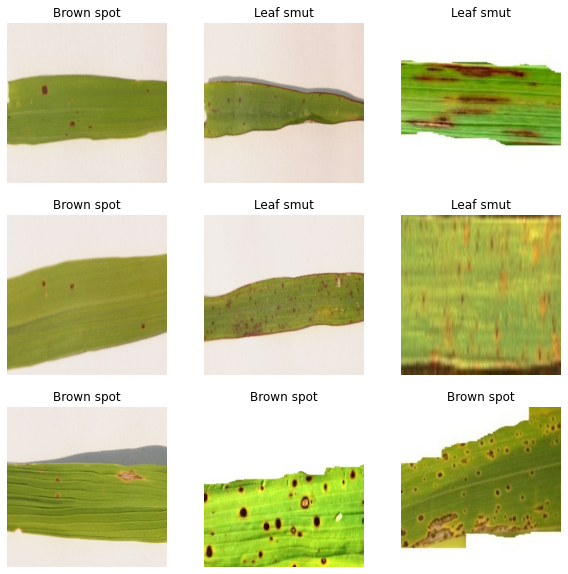

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
print("Shape of one training batch")

for image_batch, labels_batch in train_ds:
    print("Input: ", image_batch.shape)
    print("Labels: ", labels_batch.shape)
    break

Shape of one training batch
Input:  (16, 256, 256, 3)
Labels:  (16,)


In [8]:
# Pre-fetch images into memeory

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocessing the dataset

In [9]:
# Normalizing the pixel values - apply to both train and validation set

normalization_layer = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1./255)
    ])


train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
# Augmenting images in the train set to increase dataset size

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),    # Flip along both axes
        layers.experimental.preprocessing.RandomZoom(0.1),    # Randomly zoom images in dataset
    ])


print("Train size (number of batches) before augmentation: ", len(train_ds))

# Apply only to train set    
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

print("Size (number of batches) of augmented dataset: ", len(aug_ds))

#Adding to train_ds
train_ds = train_ds.concatenate(aug_ds)

print("Train size (number of batches) after augmentation: ", len(train_ds))

Train size (number of batches) before augmentation:  6
Size (number of batches) of augmented dataset:  6
Train size (number of batches) after augmentation:  12


## Model

In [11]:
# Using transfer learning
base_model = keras.applications.Xception(weights='imagenet', input_shape=(256, 256, 3), include_top=False)    # False, do not include the classification layer of the model

base_model.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer

model = keras.Model(inputs, outputs)

83689472/83683744 [==============================] - 3s 0us/step


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=16)

Epoch 1/16
12/12 [==============================] - 24s 2s/step - loss: 0.6070 - accuracy: 0.7396 - val_loss: 0.3010 - val_accuracy: 0.9167
Epoch 2/16
12/12 [==============================] - 23s 2s/step - loss: 0.1503 - accuracy: 0.9427 - val_loss: 0.3267 - val_accuracy: 0.9583
Epoch 3/16
12/12 [==============================] - 23s 2s/step - loss: 0.1960 - accuracy: 0.9271 - val_loss: 0.7607 - val_accuracy: 0.7917
Epoch 4/16
12/12 [==============================] - 23s 2s/step - loss: 0.1004 - accuracy: 0.9792 - val_loss: 0.3575 - val_accuracy: 0.9583
Epoch 5/16
12/12 [==============================] - 23s 2s/step - loss: 0.0657 - accuracy: 0.9844 - val_loss: 0.4971 - val_accuracy: 0.9167
Epoch 6/16
12/12 [==============================] - 23s 2s/step - loss: 0.0750 - accuracy: 0.9688 - val_loss: 0.4164 - val_accuracy: 0.8750
Epoch 7/16
12/12 [==============================] - 23s 2s/step - loss: 0.1123 - accuracy: 0.9688 - val_loss: 0.6510 - val_accuracy: 0.9167
Epoch 8/16
12/12 [==

In [13]:
output = model.evaluate(val_ds)

2/2 [==============================] - 1s 450ms/step - loss: 0.6189 - accuracy: 0.9167


## Plotting the metrics

In [14]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.legend([variable, variable2])
    plt.title(variable)

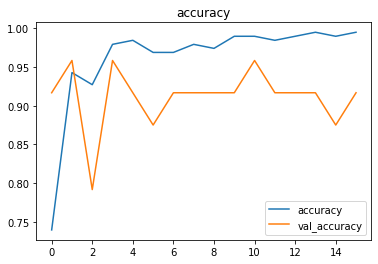

In [15]:
plot(history.history, "accuracy", 'val_accuracy')

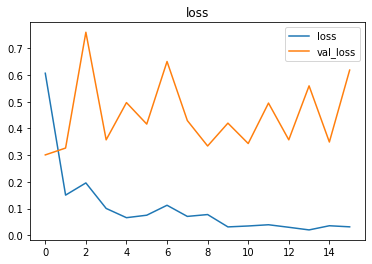

In [16]:
plot(history.history, "loss", "val_loss")

## Prediction

Prdicted:  Leaf smut
True:  Bacterial leaf blight
Probability:  0.7252307


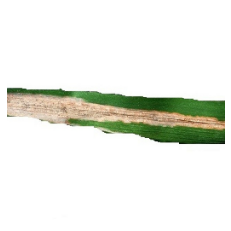

In [17]:
# pick random test data sample from one batch
x = random.randint(0, batch_size - 1)

for i in val_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (64, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Prdicted: ", class_names[pred])    # Picking the label from class_names base don the model output
    print("True: ", class_names[label[x]])
    print("Probability: ", output[0][pred])
    break

## deepC

In [18]:
model.save('rice_leaf_disease.h5')

!deepCC rice_leaf_disease.h5

reading [keras model] from 'rice_leaf_disease.h5'
Saved 'rice_leaf_disease.onnx'
reading onnx model from file  rice_leaf_disease.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): spatial is not a valid graph-node attribute.
             operator BatchNormalization will be added without this attribute.
WARN (ONNX): spatial is not a valid graph-node attribute.
             operator BatchNormalization will be added without this attribute.
WARN (ONNX): graph-node block2_sepconv10's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv11's attribute auto_pad has no meaningful data.
WARN (ONNX): spatial is not a valid graph-node attribute.
             operator BatchNormalization will be added without this attribute.
WARN (ONNX): graph-node block2_sepconv20's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv21's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d's attribute auto_pad has no meaning